## Kaggle Dataset : Using News to predict Stock Movements

https://www.kaggle.com/c/two-sigma-financial-news


### Parameters in market data : 

- time(datetime64[ns, UTC]) - the current time (in marketdata, all rows are taken at 22:00 UTC)
- assetCode(object) - a unique id of an asset
- assetName(category) - the name that corresponds to a group of assetCodes. These may be "Unknown" if the corresponding assetCode does not have any rows in the news data.
- universe(float64) - a boolean indicating whether or not the instrument on that day will be included in scoring. This value is not provided outside of the training data time period. The trading universe on a given date is the set of instruments that are avilable for trading (the scoring function will not consider instruments that are not in the trading universe). The trading universe changes daily.
- volume(float64) - trading volume in shares for the day
- close(float64) - the close price for the day (not adjusted for splits or dividends)
- open(float64) - the open price for the day (not adjusted for splits or dividends)


The marketdata contains a variety of returns calculated over different timespans. All of the returns in this set of marketdata have these properties:

Returns are always calculated either open-to-open (from the opening time of one trading day to the open of another) or close-to-close (from the closing time of one trading day to the open of another).
Returns are either raw, meaning that the data is not adjusted against any benchmark, or market-residualized (Mktres), meaning that the movement of the market as a whole has been accounted for, leaving only movements inherent to the instrument.
Returns can be calculated over any arbitrary interval. Provided here are 1 day and 10 day horizons.
Returns are tagged with 'Prev' if they are backwards looking in time, or 'Next' if forwards looking.

- returnsClosePrevRaw1(float64) - see returns explanation above
- returnsClosePrevRaw10(float64) - see returns explanation above
- returnsOpenPrevRaw1(float64) - see returns explanation above
- returnsOpenPrevRaw10(float64) - see returns explanation above
- returnsClosePrevMktres1(float64) - see returns explanation above
- returnsClosePrevMktres10(float64) - see returns explanation above
- returnsOpenPrevMktres1(float64) - see returns explanation above
- returnsOpenPrevMktres10(float64) - see returns explanation above
- <b>returnsOpenNextMktres10(float64) </b>- 10 day, market-residualized return. This is the <b>target</b> variable used in competition scoring. The market data has been filtered such that returnsOpenNextMktres10 is always not null.


### Parameters in News data
The news data contains information at both the news article level and asset level (in other words, the table is intentionally not normalized).

- time(datetime64[ns, UTC]) - UTC timestamp showing when the data was available on the feed (second precision)
- sourceTimestamp(datetime64[ns, UTC]) - UTC timestamp of this news item when it was created
- firstCreated(datetime64[ns, UTC]) - UTC timestamp for the first version of the item
- sourceId(object) - an Id for each news item
- headline(object) - the item's headline
- urgency(int8) - differentiates story types (1: alert, 3: article)
- takeSequence(int16) - the take sequence number of the news item, starting at 1. For a given story, alerts and articles have separate sequences.
- provider(category) - identifier for the organization which provided the news item (e.g. RTRS for Reuters News, BSW for Business Wire)
- subjects(category) - topic codes and company identifiers that relate to this news item. Topic codes describe the news item's subject matter. These can cover asset classes, geographies, events, industries/sectors, and other types.
- audiences(category) - identifies which desktop news product(s) the news item belongs to. They are typically tailored to specific audiences. (e.g. "M" for Money International News Service and "FB" for French General News Service)
- bodySize(int32) - the size of the current version of the story body in characters
- companyCount(int8) - the number of companies explicitly listed in the news item in the subjects field
- headlineTag(object) - the Thomson Reuters headline tag for the news item
- marketCommentary(bool) - boolean indicator that the item is discussing general market conditions, such as "After the Bell" summaries
- sentenceCount(int16) - the total number of sentences in the news item. Can be used in conjunction with firstMentionSentence to determine the relative position of the first mention in the item.
- wordCount(int32) - the total number of lexical tokens (words and punctuation) in the news item
- assetCodes(category) - list of assets mentioned in the item
- assetName(category) - name of the asset
- firstMentionSentence(int16) - the first sentence, starting with the headline, in which the scored asset is mentioned.
 1: headline
 2: first sentence of the story body
 3: second sentence of the body, etc
 0: the asset being scored was not found in the news item's headline or body text. As a result, the entire news item's text (headline + body) will be used to determine the sentiment score.
- relevance(float32) - a decimal number indicating the relevance of the news item to the asset. It ranges from 0 to 1. If the asset is mentioned in the headline, the relevance is set to 1. When the item is an alert (urgency == 1), relevance should be gauged by firstMentionSentence instead.
- sentimentClass(int8) - indicates the predominant sentiment class for this news item with respect to the asset. The indicated - - - class is the one with the highest probability.
- sentimentNegative(float32) - probability that the sentiment of the news item was negative for the asset
- sentimentNeutral(float32) - probability that the sentiment of the news item was neutral for the asset
- sentimentPositive(float32) - probability that the sentiment of the news item was positive for the asset
- sentimentWordCount(int32) - the number of lexical tokens in the sections of the item text that are deemed relevant to the asset. This can be used in conjunction with wordCount to determine the proportion of the news item discussing the asset.
- noveltyCount12H(int16) - The 12 hour novelty of the content within a news item on a particular asset. It is calculated by comparing it with the asset-specific text over a cache of previous news items that contain the asset.
- noveltyCount24H(int16) - same as above, but for 24 hours
- noveltyCount3D(int16) - same as above, but for 3 days
- noveltyCount5D(int16) - same as above, but for 5 days
- noveltyCount7D(int16) - same as above, but for 7 days
- volumeCounts12H(int16) - the 12 hour volume of news for each asset. A cache of previous news items is maintained and the number of news items that mention the asset within each of five historical periods is calculated.
- volumeCounts24H(int16) - same as above, but for 24 hours
- volumeCounts3D(int16) - same as above, but for 3 days
- volumeCounts5D(int16) - same as above, but for 5 days
- volumeCounts7D(int16) - same as above, but for 7 days

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
# pre-processing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# clustering (used for determining how well the
# features are for solving the classification problem)
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import homogeneity_completeness_v_measure

# classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

import lightgbm as lgb


%matplotlib inline

## Data Cleaning for market data

In [2]:
# Simple data cleaning to change the time from float to time and filter dates from 2013-01-24 onwards
df = pd.read_csv("market.csv")
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
mask=df["time"]>"2013-01-24"
market_df=df[mask]
market_df.assetCode = market_df.assetCode.astype(str)
# remove additional column
market_df.drop(columns=["Unnamed: 0"], inplace=True)


/home/SY/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/SY/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Data Cleanning for News data


In [4]:
# Filter the news dataset to start from the same time as market data
news_df = pd.read_csv("news.csv")
news_df['time'] = pd.to_datetime(news_df['time'], infer_datetime_format=True)
mask=news_df["time"]>"2013-01-24"
news_df=news_df[mask]


/home/SY/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087199 entries, 1793 to 1088991
Data columns (total 36 columns):
Unnamed: 0              1087199 non-null int64
time                    1087199 non-null datetime64[ns]
sourceTimestamp         1087199 non-null object
firstCreated            1087198 non-null object
sourceId                1087198 non-null object
headline                1087023 non-null object
urgency                 1087198 non-null float64
takeSequence            1087198 non-null float64
provider                1087198 non-null object
subjects                1087198 non-null object
audiences               1087198 non-null object
bodySize                1087198 non-null float64
companyCount            1087198 non-null float64
headlineTag             348299 non-null object
marketCommentary        1087198 non-null object
sentenceCount           1087198 non-null float64
wordCount               1087198 non-null float64
assetCodes              1087198 non-null object
assetNam

In [6]:
def preprocess_news(news_train):
# Due to huge datasize i would just start the analysis from 2013-01-24 onwards 
# Drop the headlineTag as almost 75% of the dataset are empty

    drop_list = [
        "Unnamed: 0", "sourceTimestamp", "firstCreated", "sourceId", "headlineTag"
    ]
    news_train.drop(drop_list, axis=1, inplace=True)
    
    # assetCodes is in {"AVC.N", "XXX.B", "ZZZ.C"}, need to remove {} and '' from assetCodes column
    news_train.assetCodes = news_train.assetCodes.astype(str)

    news_train['assetCodes'] = news_train['assetCodes'].apply(lambda x: x[1:-1].replace("'", ""))
    return news_train


In [7]:
import gc

def unstack_asset_codes(news_train):
# asset codes is an array of individual asset code. Therefore, would need to unstack each asset code and save the 
# original index in order to merge the market_df

    
    codes = []
    indexes = []
    for i, values in news_train['assetCodes'].iteritems():
        explode = values.split(",")
        codes.extend(explode)
        repeat_index = [int(i)]*len(explode)
        indexes.extend(repeat_index)
    index_df = pd.DataFrame({'news_index': indexes, 'assetCode': codes})
    del codes, indexes
    gc.collect()
    return index_df


def merge_news_on_index(news_train, index_df):
    news_train['news_index'] = news_train.index.copy()

    # Merge news on unstacked assets
    news_unstack = pd.merge(index_df, news_train, how='inner', on=['news_index'])
    news_unstack.drop(['news_index', 'assetCodes'], axis=1, inplace=True)
    return news_unstack


news_train = preprocess_news(news_df)

index_df = unstack_asset_codes(news_train)
index_df.head()

news_unstack = merge_news_on_index(news_train, index_df)

In [8]:
def group_news(news_frame):
    """
    Group news by date and asset

There can be many News for a single date and asset, 
so we need to group this data. I'll be using a simple mean, but you can use more intelligent features.
    """
    
    news_frame['date'] = news_frame.time.dt.date  # Add date column
    
    aggregations = ['mean']
    gp = news_frame.groupby(['assetCode', 'date']).agg(aggregations) # aggregate mean for each column 
    # multi-level index to combine the column name and mean together
    gp.columns = pd.Index(["{}_{}".format(e[0], e[1]) for e in gp.columns.tolist()]) 
    gp.reset_index(inplace=True)
    print(news_frame.head(5))
    # Set datatype to float32
    float_cols = {c: 'float32' for c in gp.columns if c not in ['assetCode', 'date']}
    return gp.astype(float_cols)

news_agg = group_news(news_unstack)
news_agg.head(3)


  assetCode                time  \
0      BX.N 2013-01-24 00:00:20   
1      CT.N 2013-01-24 00:00:20   
2    MAPP.O 2013-01-24 00:01:01   
3    MANU.N 2013-01-24 00:01:01   
4    HPQ.DE 2013-01-24 00:01:54   

                                            headline  urgency  takeSequence  \
0  Capital Trust, Inc. Announces Tax Treatment Of...      3.0           1.0   
1  Capital Trust, Inc. Announces Tax Treatment Of...      3.0           1.0   
2  Faruqi & Faruqi, LLP Is Seeking More Cash For ...      3.0           1.0   
3  Soccer-Real Madrid, Barcelona retain grip on e...      3.0           1.0   
4  BREAKINGVIEWS-Apple finally succumbs to uncrea...      3.0           1.0   

  provider                                           subjects  \
0      PRN  {'FIN', 'FUND', 'REAL', 'REIT', 'NEWR', 'PVE',...   
1      PRN  {'FIN', 'FUND', 'REAL', 'REIT', 'NEWR', 'PVE',...   
2      BSW  {'CMSS', 'CLJ', 'GEN', 'NEWR', 'HECA', 'PHMR',...   
3     RTRS  {'DE', 'ES', 'FINS', 'RTRS', 'LEN', 'CYCS'

,assetCode,date,urgency_mean,takeSequence_mean,bodySize_mean,companyCount_mean,sentenceCount_mean,wordCount_mean,firstMentionSentence_mean,relevance_mean,...,noveltyCount12H_mean,noveltyCount24H_mean,noveltyCount3D_mean,noveltyCount5D_mean,noveltyCount7D_mean,volumeCounts12H_mean,volumeCounts24H_mean,volumeCounts3D_mean,volumeCounts5D_mean,volumeCounts7D_mean
0,0005.HK,2013-01-24,3.0,1.055556,1696.333374,2.833333,12.333333,312.500000,3.555556,0.699305,...,0.388889,0.722222,0.722222,0.722222,0.722222,7.944445,15.611111,44.222221,48.500000,58.833332
1,0005.HK,2013-01-25,3.0,1.000000,2249.899902,3.300000,12.000000,331.799988,1.300000,0.335612,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.600000,10.700000,41.200001,62.400002,69.300003
2,0005.HK,2013-01-27,3.0,1.000000,5857.000000,5.500000,35.500000,1014.000000,12.500000,0.193576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,11.500000,40.000000,68.000000


In [9]:
"""
Merge market data
"""

market_df['date'] = market_df.time.dt.date

# extract the assetcode that have news
news_assetlist= pd.merge(market_df, news_agg, how='inner', on=['date', 'assetCode'])
news_assetlist = pd.DataFrame(news_assetlist["assetCode"].unique(), columns=["assetCode"])

# merge the market_df with the asset code that have news
market_df = market_df.merge(news_assetlist, how='inner', on=['assetCode']).drop_duplicates()

# merge the filtered market_df news df with news_df
merge_df = market_df.merge(news_agg, how='left', on=['assetCode', 'date'])
merge_df =merge_df.sort_values(by=['assetCode', "date"]).reset_index(drop=True)
merge_df

/home/SY/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,...,noveltyCount12H_mean,noveltyCount24H_mean,noveltyCount3D_mean,noveltyCount5D_mean,noveltyCount7D_mean,volumeCounts12H_mean,volumeCounts24H_mean,volumeCounts3D_mean,volumeCounts5D_mean,volumeCounts7D_mean
0,2013-01-24 22:00:00,A.N,Agilent Technologies Inc,3111905.0,44.66,44.56,0.008126,0.000449,0.008118,-0.000776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,1.500000,1.500000,1.500000
1,2013-01-25 22:00:00,A.N,Agilent Technologies Inc,3177774.0,45.29,44.73,0.014107,0.003815,0.006845,0.003809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-28 22:00:00,A.N,Agilent Technologies Inc,2371265.0,45.18,45.19,-0.002429,0.010284,0.000054,0.005198,...,1.666667,1.750000,1.750000,1.750000,1.750000,6.583333,7.333333,7.333333,9.333333,10.333333
3,2013-01-29 22:00:00,A.N,Agilent Technologies Inc,2951235.0,44.64,44.96,-0.011952,-0.005090,-0.018541,-0.003351,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,5.500000,14.500000,14.500000,17.000000
4,2013-01-30 22:00:00,A.N,Agilent Technologies Inc,2943121.0,44.40,44.58,-0.005376,-0.008452,-0.000686,-0.012797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-01-31 22:00:00,A.N,Agilent Technologies Inc,3384082.0,44.78,44.35,0.008559,-0.005159,0.011183,-0.002080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,16.000000,16.000000
6,2013-02-01 22:00:00,A.N,Agilent Technologies Inc,2827834.0,45.29,45.08,0.011389,0.016460,-0.002547,0.016042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,17.000000,17.000000
7,2013-02-04 22:00:00,A.N,Agilent Technologies Inc,3470949.0,44.26,44.80,-0.022742,-0.006211,-0.003714,-0.006141,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,1.500000,2.500000,9.000000
8,2013-02-05 22:00:00,A.N,Agilent Technologies Inc,2162212.0,45.00,44.56,0.016719,-0.005357,0.000470,-0.002568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2013-02-06 22:00:00,A.N,Agilent Technologies Inc,2756374.0,45.09,44.72,0.002000,0.003591,0.001157,0.001798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# to have data greater than 10days bcoz i would be creating history for the past 10days as variables
days=10
merge_df.groupby('assetCode').filter(lambda x: x['assetCode'].count() > days)


,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,...,noveltyCount12H_mean,noveltyCount24H_mean,noveltyCount3D_mean,noveltyCount5D_mean,noveltyCount7D_mean,volumeCounts12H_mean,volumeCounts24H_mean,volumeCounts3D_mean,volumeCounts5D_mean,volumeCounts7D_mean
0,2013-01-24 22:00:00,A.N,Agilent Technologies Inc,3111905.0,44.66,44.56,0.008126,0.000449,0.008118,-0.000776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,1.500000,1.500000,1.500000
1,2013-01-25 22:00:00,A.N,Agilent Technologies Inc,3177774.0,45.29,44.73,0.014107,0.003815,0.006845,0.003809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-28 22:00:00,A.N,Agilent Technologies Inc,2371265.0,45.18,45.19,-0.002429,0.010284,0.000054,0.005198,...,1.666667,1.750000,1.750000,1.750000,1.750000,6.583333,7.333333,7.333333,9.333333,10.333333
3,2013-01-29 22:00:00,A.N,Agilent Technologies Inc,2951235.0,44.64,44.96,-0.011952,-0.005090,-0.018541,-0.003351,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,5.500000,14.500000,14.500000,17.000000
4,2013-01-30 22:00:00,A.N,Agilent Technologies Inc,2943121.0,44.40,44.58,-0.005376,-0.008452,-0.000686,-0.012797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-01-31 22:00:00,A.N,Agilent Technologies Inc,3384082.0,44.78,44.35,0.008559,-0.005159,0.011183,-0.002080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,16.000000,16.000000
6,2013-02-01 22:00:00,A.N,Agilent Technologies Inc,2827834.0,45.29,45.08,0.011389,0.016460,-0.002547,0.016042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,17.000000,17.000000
7,2013-02-04 22:00:00,A.N,Agilent Technologies Inc,3470949.0,44.26,44.80,-0.022742,-0.006211,-0.003714,-0.006141,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,1.500000,2.500000,9.000000
8,2013-02-05 22:00:00,A.N,Agilent Technologies Inc,2162212.0,45.00,44.56,0.016719,-0.005357,0.000470,-0.002568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2013-02-06 22:00:00,A.N,Agilent Technologies Inc,2756374.0,45.09,44.72,0.002000,0.003591,0.001157,0.001798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
merge_df.fillna(0, inplace=True)
merge_df["label"]=merge_df['returnsOpenNextMktres10'].map(lambda x: 0 if x<0 else 1).values

merge_df.isnull().sum()

time                         0
assetCode                    0
assetName                    0
volume                       0
close                        0
open                         0
returnsClosePrevRaw1         0
returnsOpenPrevRaw1          0
returnsClosePrevMktres1      0
returnsOpenPrevMktres1       0
returnsClosePrevRaw10        0
returnsOpenPrevRaw10         0
returnsClosePrevMktres10     0
returnsOpenPrevMktres10      0
returnsOpenNextMktres10      0
universe                     0
date                         0
urgency_mean                 0
takeSequence_mean            0
bodySize_mean                0
companyCount_mean            0
sentenceCount_mean           0
wordCount_mean               0
firstMentionSentence_mean    0
relevance_mean               0
sentimentClass_mean          0
sentimentNegative_mean       0
sentimentNeutral_mean        0
sentimentPositive_mean       0
sentimentWordCount_mean      0
noveltyCount12H_mean         0
noveltyCount24H_mean         0
noveltyC

In [33]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178000 entries, 0 to 1177999
Data columns (total 41 columns):
time                         1178000 non-null datetime64[ns]
assetCode                    1178000 non-null object
assetName                    1178000 non-null object
volume                       1178000 non-null float64
close                        1178000 non-null float64
open                         1178000 non-null float64
returnsClosePrevRaw1         1178000 non-null float64
returnsOpenPrevRaw1          1178000 non-null float64
returnsClosePrevMktres1      1174514 non-null float64
returnsOpenPrevMktres1       1174510 non-null float64
returnsClosePrevRaw10        1178000 non-null float64
returnsOpenPrevRaw10         1178000 non-null float64
returnsClosePrevMktres10     1159617 non-null float64
returnsOpenPrevMktres10      1159595 non-null float64
returnsOpenNextMktres10      1178000 non-null float64
universe                     1178000 non-null float64
date              

## To add in past 10days data as parameters

In [12]:

def sequence_to_supervised_learning(series, window_size, text):
    """Transforms a sequence into a supervised
    learning dataset
    
    Inputs:
        series - the input sequence
        window_size - the window sizes to create
    Output:
        a supervised learning dataset, of window size as features
        and the current value as the target
    """
    result = series.copy()
    for i in range(window_size):
        # shift the series forward by 1 step each time
        # then append the shifted series to the result
        result = pd.concat([result, series.shift(-(i+1))], axis=1)

    # last window_size rows will have missing values because
    # they are shifted into the future
    result.dropna(inplace=True)
    c=[]
    i=window_size
    while i<(window_size+1):
        b=text+" t-"+str(i)
        c.append(b)
        i=i-1
        if i==0:
            c.append(text+' t')
            break
    result.columns = c

    return result

In [13]:
window_size = 10

df_close = merge_df.groupby('assetCode')["close"].apply(sequence_to_supervised_learning, window_size=window_size, text="close")
df_open = merge_df.groupby('assetCode')["open"].apply(sequence_to_supervised_learning, window_size=window_size, text="open")


In [14]:
# it hv become a multi-range index as I groupby different assetcode, I would need to reset the index to level 1
df_close.reset_index(inplace=True)
df_close.set_index('level_1', inplace=True)
df_open.reset_index(inplace=True)
df_open.set_index('level_1', inplace=True)
merge_df1 = merge_df.iloc[9:].reset_index(drop=True)


In [15]:
# merge the new dataframe based on index 
merged = merge_df1.merge(df_close, left_index=True, right_index=True, how='inner')
merged = merged.merge(df_open, left_index=True, right_index=True, how='inner')
merged

,time,assetCode_x,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,...,open t-9,open t-8,open t-7,open t-6,open t-5,open t-4,open t-3,open t-2,open t-1,open t
0,2013-02-06 22:00:00,A.N,Agilent Technologies Inc,2756374.0,45.09,44.72,0.002000,0.003591,0.001157,0.001798,...,44.73,45.19,44.96,44.58,44.35,45.08,44.80,44.56,44.72,44.90
1,2013-02-07 22:00:00,A.N,Agilent Technologies Inc,3142595.0,45.01,44.90,-0.001774,0.004025,0.000928,0.003956,...,45.19,44.96,44.58,44.35,45.08,44.80,44.56,44.72,44.90,45.07
2,2013-02-08 22:00:00,A.N,Agilent Technologies Inc,1824755.0,45.08,45.07,0.001555,0.003786,-0.006395,0.004179,...,44.96,44.58,44.35,45.08,44.80,44.56,44.72,44.90,45.07,45.17
3,2013-02-11 22:00:00,A.N,Agilent Technologies Inc,2915405.0,44.60,45.17,-0.010648,0.002219,-0.009752,0.001139,...,44.58,44.35,45.08,44.80,44.56,44.72,44.90,45.07,45.17,44.81
4,2013-02-12 22:00:00,A.N,Agilent Technologies Inc,2373731.0,44.62,44.81,0.000448,-0.007970,-0.001886,-0.007813,...,44.35,45.08,44.80,44.56,44.72,44.90,45.07,45.17,44.81,44.81
5,2013-02-13 22:00:00,A.N,Agilent Technologies Inc,2052338.0,44.75,44.81,0.002913,0.000000,0.002036,-0.000381,...,45.08,44.80,44.56,44.72,44.90,45.07,45.17,44.81,44.81,44.72
6,2013-02-14 22:00:00,A.N,Agilent Technologies Inc,3845682.0,44.58,44.72,-0.003799,-0.002008,-0.004823,-0.002131,...,44.80,44.56,44.72,44.90,45.07,45.17,44.81,44.81,44.72,43.48
7,2013-02-15 22:00:00,A.N,Agilent Technologies Inc,14657415.0,42.25,43.48,-0.052266,-0.027728,-0.050450,-0.027907,...,44.56,44.72,44.90,45.07,45.17,44.81,44.81,44.72,43.48,42.21
8,2013-02-19 22:00:00,A.N,Agilent Technologies Inc,4116141.0,43.01,42.21,0.017988,-0.029209,0.005267,-0.028745,...,44.72,44.90,45.07,45.17,44.81,44.81,44.72,43.48,42.21,42.84
9,2013-02-20 22:00:00,A.N,Agilent Technologies Inc,3873183.0,42.24,42.84,-0.017903,0.014925,0.001673,0.011038,...,44.90,45.07,45.17,44.81,44.81,44.72,43.48,42.21,42.84,42.14


In [16]:
# Drop some additional columns after merging 
drop_list = ["time", "assetName", "assetCode_x", 'assetCode_y', "open t", "close t", "open", "close", "universe", "returnsOpenNextMktres10"]
merged.drop(drop_list, axis=1, inplace=True)


In [17]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1161833 entries, 0 to 1177989
Data columns (total 55 columns):
volume                       1161833 non-null float64
returnsClosePrevRaw1         1161833 non-null float64
returnsOpenPrevRaw1          1161833 non-null float64
returnsClosePrevMktres1      1161833 non-null float64
returnsOpenPrevMktres1       1161833 non-null float64
returnsClosePrevRaw10        1161833 non-null float64
returnsOpenPrevRaw10         1161833 non-null float64
returnsClosePrevMktres10     1161833 non-null float64
returnsOpenPrevMktres10      1161833 non-null float64
date                         1161833 non-null object
urgency_mean                 1161833 non-null float32
takeSequence_mean            1161833 non-null float32
bodySize_mean                1161833 non-null float32
companyCount_mean            1161833 non-null float32
sentenceCount_mean           1161833 non-null float32
wordCount_mean               1161833 non-null float32
firstMentionSentence_mea

In [18]:
# yet to drop "date", "assetCode"

df = merged.copy(deep=True)


## Feature Engineering 
PCA plot

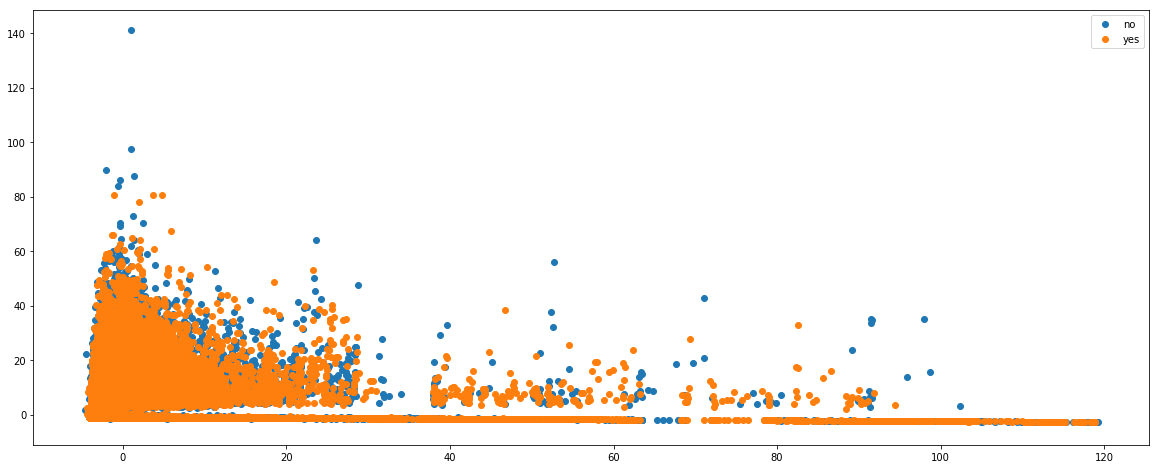

In [19]:

target="label"
features = (df.columns != target) & (df.columns != 'assetCode') & (df.columns != 'date')

# id is not useful

X = df.loc[:, features]
y = df[target]

scaler = StandardScaler()
Z_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2) # 2 components to plot 2d,
                          # coloured based on yes/no
Z_2d = pca.fit_transform(Z_scaled)
fig, ax = plt.subplots(figsize=(20, 8))


# plotting 1st vs. 2nd PCA component
ax.scatter(Z_2d[y==0, 0], Z_2d[y==0, 1], label='no') # filter for y==0
ax.scatter(Z_2d[y==1, 0], Z_2d[y==1, 1], label='yes') # filter for y==1
ax.legend()

## Train, test, split

In [20]:
# train_test_split
from sklearn.model_selection import train_test_split

Z_train, Z_test, y_train, y_test = train_test_split(Z_scaled, y,shuffle=False)

## Model Engineering

Log loss, also called logistic regression loss or cross-entropy loss, is defined on probability estimates. It is commonly used in (multinomial) logistic regression and neural networks, as well as in some variants of expectation-maximization, and can be used to evaluate the probability outputs (predict_proba) of a classifier instead of its discrete predictions.

https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

Light GBM is a gradient boosting framework that uses tree based learning algorithm. Light GBM is prefixed as ‘Light’ because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results.

In [ ]:
from sklearn.metrics import log_loss


param_grid = {
    'learning_rate': [0.15, 0.1, 0.05, 0.02, 0.01],
    'num_leaves': [i for i in range(12, 90, 6)],
    'n_estimators': [50, 200, 400, 600, 800],
    'min_child_samples': [i for i in range(10, 100, 10)],
    'colsample_bytree': [0.8, 0.9, 0.95, 1],
    'subsample': [0.8, 0.9, 0.95, 1],
    'reg_alpha': [0.1, 0.2, 0.4, 0.6, 0.8],
    'reg_lambda': [0.1, 0.2, 0.4, 0.6, 0.8],
    'objective' : ['binary'],
    'metric' : ['binary_logloss']
}
best_eval_score = 0

for i in range(30):  # based on last run
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
#    score = evaluate_model(df, y_train, train_index, test_index, params)
    params['n_jobs'] = 2  # Use 2 cores/threads
    model = lgb.LGBMClassifier(**params)
    model.fit(Z_train, y_train)
    score=log_loss(y_test, model.predict_proba(Z_test))

    
    print("run"+ str(i))
    if score < best_eval_score or best_eval_score == 0:
        best_eval_score = score
        best_params = params
        print(best_eval_score)
        print(best_params)

print("Best evaluation logloss", best_eval_score)

In [56]:
best_params

{'colsample_bytree': 1.0,
 'learning_rate': 0.02,
 'metric': 'binary_logloss',
 'min_child_samples': 30,
 'n_estimators': 800,
 'n_jobs': 2,
 'num_leaves': 12,
 'objective': 'binary',
 'reg_alpha': 0.8,
 'reg_lambda': 0.1,
 'subsample': 0.9}

In [21]:
best_params = {'colsample_bytree': 1.0,
 'learning_rate': 0.02,
 'min_child_samples': 30,
 'n_estimators': 800,
 'n_jobs': 2,
 'num_leaves': 12,
 'reg_alpha': 0.8,
 'reg_lambda': 0.1,
 'subsample': 0.9,
 'objective': 'binary',
 'metric': 'binary_logloss'}


"""
{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'metric': 'binary_logloss',
 'min_child_samples': 20,
 'n_estimators': 600,
 'n_jobs': 2,
 'num_leaves': 84,
 'objective': 'binary',
 'reg_alpha': 0.8,
 'reg_lambda': 0.4,
 'subsample': 1.0}


using openNext
"""

"\n{'colsample_bytree': 1.0,\n 'learning_rate': 0.01,\n 'metric': 'binary_logloss',\n 'min_child_samples': 20,\n 'n_estimators': 600,\n 'n_jobs': 2,\n 'num_leaves': 84,\n 'objective': 'binary',\n 'reg_alpha': 0.8,\n 'reg_lambda': 0.4,\n 'subsample': 1.0}\n\n\nusing openNext\n"

In [22]:
clf = lgb.LGBMClassifier(**best_params)
clf.fit(Z_train, y_train)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        metric='binary_logloss', min_child_samples=30,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
        n_jobs=2, num_leaves=12, objective='binary', random_state=None,
        reg_alpha=0.8, reg_lambda=0.1, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=0)

In [23]:
from sklearn.metrics import accuracy_score # Accuracy classification score.


print('Training accuracy: ', accuracy_score(y_train, clf.predict(Z_train)))
print('Validation accuracy: ', accuracy_score(y_test, clf.predict(Z_test)))


/home/SY/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training accuracy:  0.5561481063240353
Validation accuracy:  0.552611556192096


/home/SY/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [24]:
y_pred = clf.predict(Z_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

/home/SY/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.55      0.52      0.53    143967
          1       0.55      0.59      0.57    146492

avg / total       0.55      0.55      0.55    290459

[[74460 69507]
 [60441 86051]]


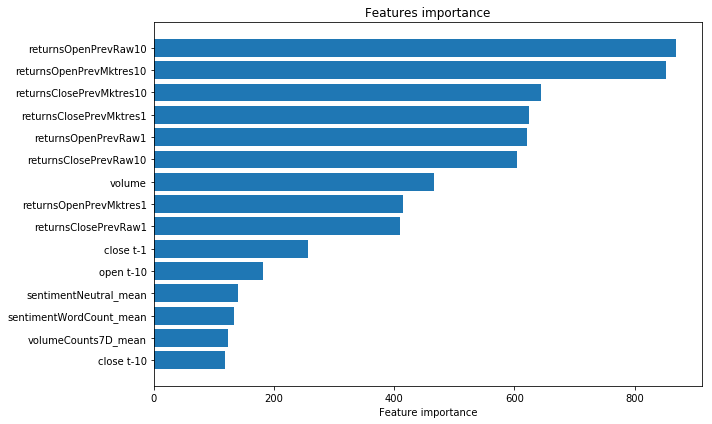

In [35]:
Z_test.shape

(290459, 52)

In [34]:
# explain the samples from the validation set
# each row is an explanation for a sample, and the last column in the base rate of the model
# the sum of each row is the margin (log odds) output of the model for that sample

import shap

shap_values = shap.TreeExplainer(clf.booster_).shap_values(pd.DataFrame(Z_test))
#shap_values = shap.TreeExplainer(clf.booster_).shap_values(pd.DataFrame(Z_test).iloc[:290459,:])

shap_values.shape

(290459, 52)

In [ ]:
# compute the global importance of each feature as the mean absolute value
# of the feature's importance over all the samples
global_importances = np.abs(shap_values).mean(0)[:-1]


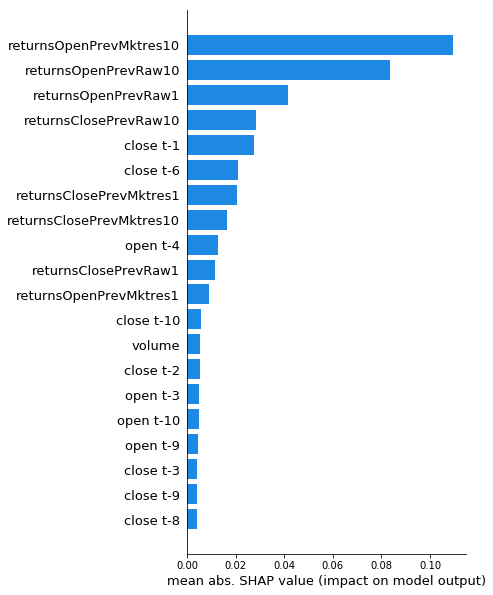

In [36]:
# Top 20 features
features_imp['features'] = list(feature_columns)[:]
# make a bar chart that shows the global importance of the top 20 features
inds = np.argsort(-global_importances)
f = plt.figure(figsize=(5,10))
y_pos = np.arange(20)
inds2 = np.flip(inds[:20], 0)
plt.barh(y_pos, global_importances[inds2], align='center', color="#1E88E5")
plt.yticks(y_pos, fontsize=13)
plt.gca().set_yticklabels(X.columns[inds2])
plt.xlabel('mean abs. SHAP value (impact on model output)', fontsize=13)
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

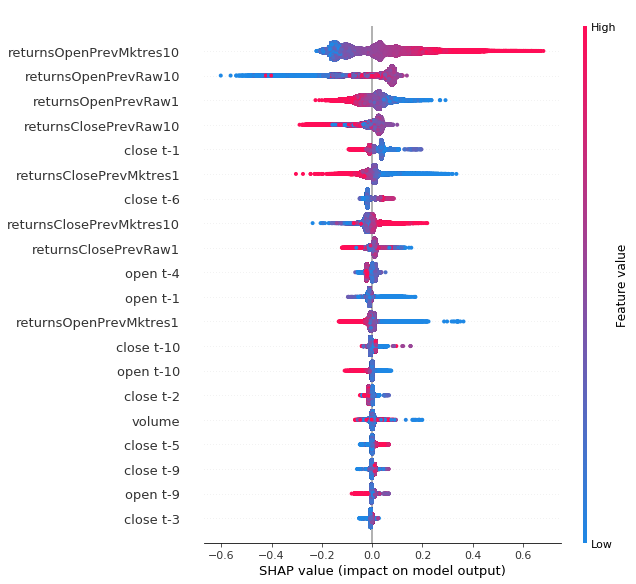

In [45]:
#shap.summary_plot(shap_values, pd.DataFrame(Z_test).iloc[:290459,:])
val=pd.DataFrame(Z_test, columns=X.columns)
shap.summary_plot(shap_values, val)


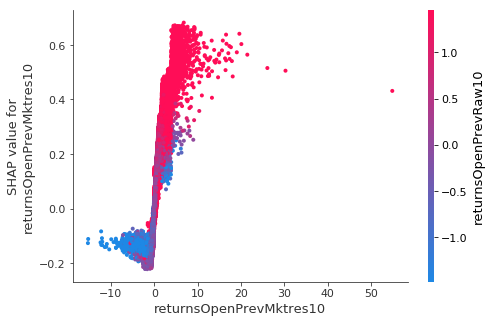

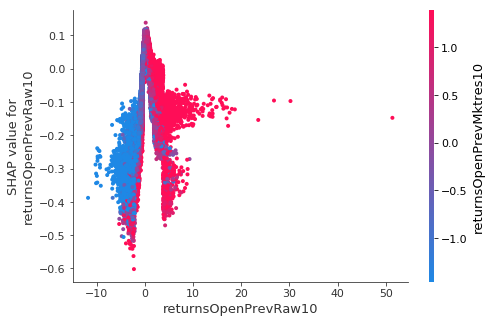

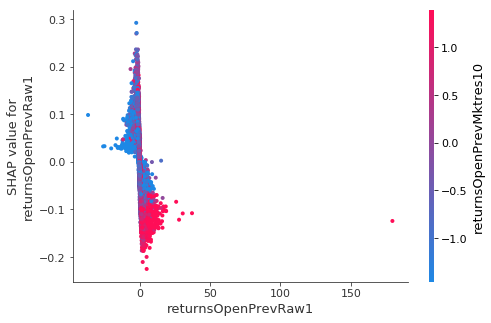

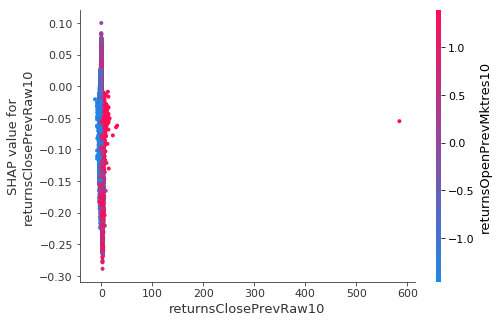

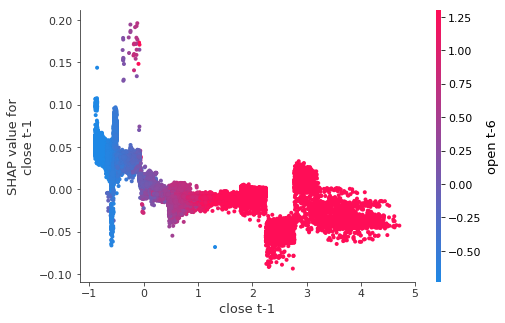

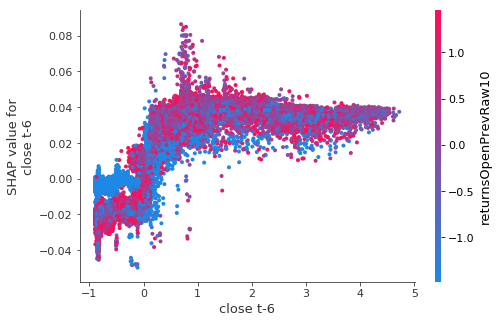

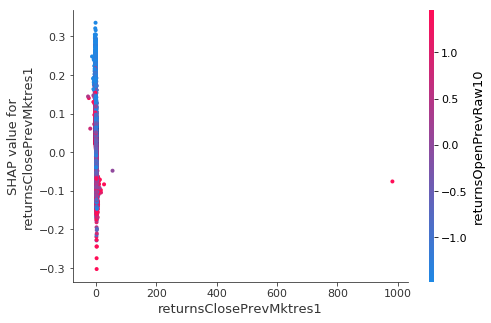

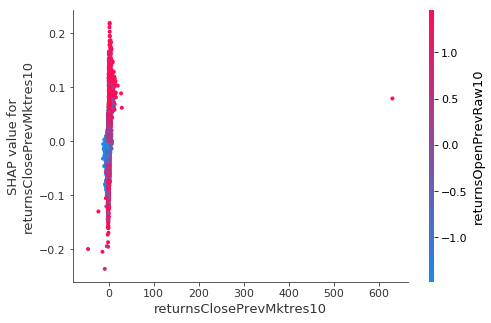

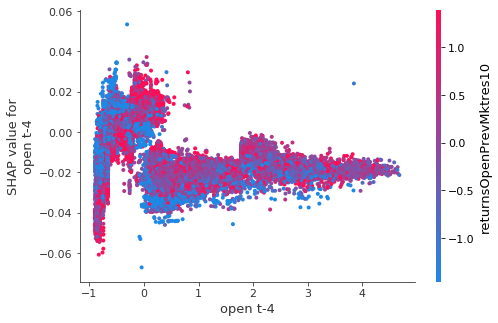

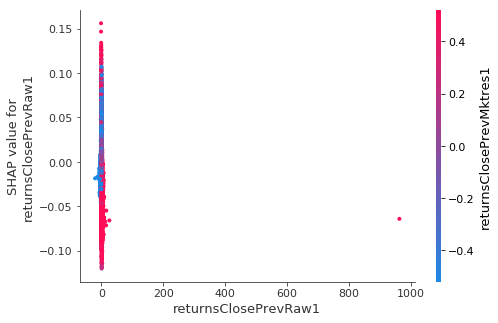

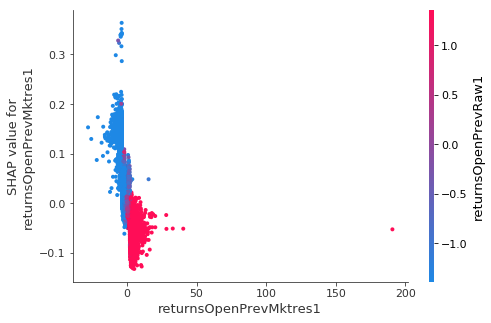

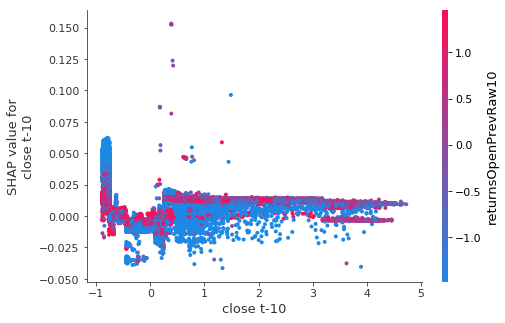

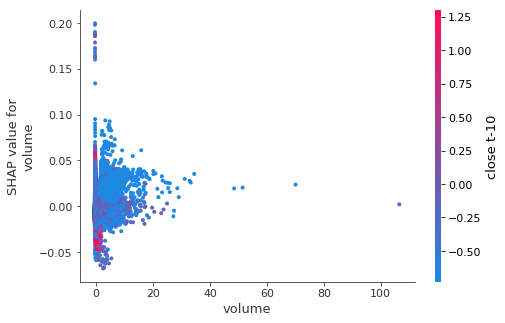

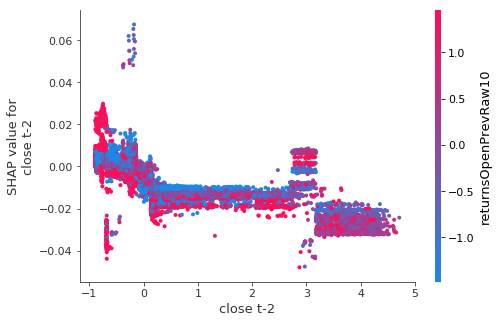

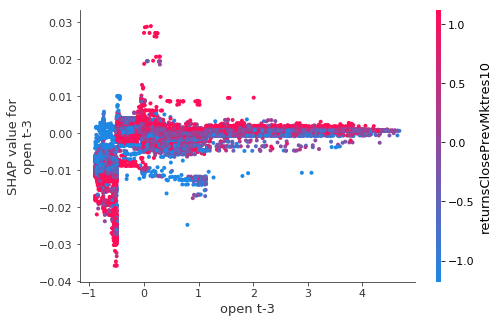

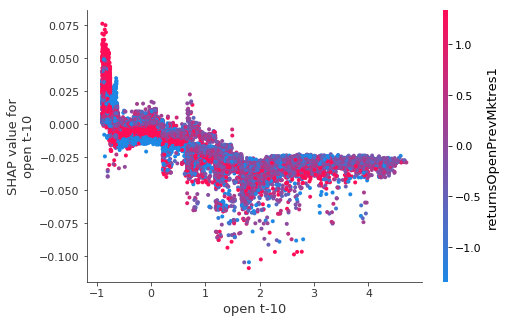

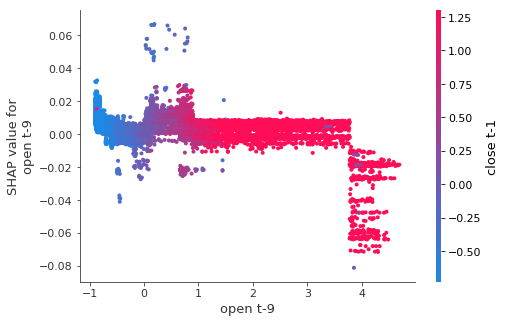

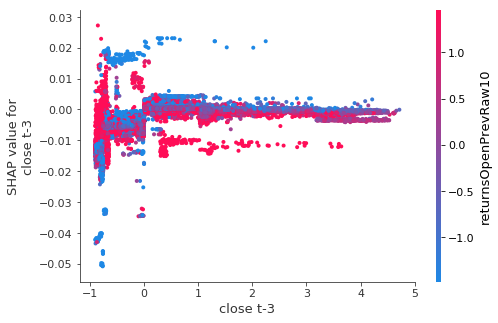

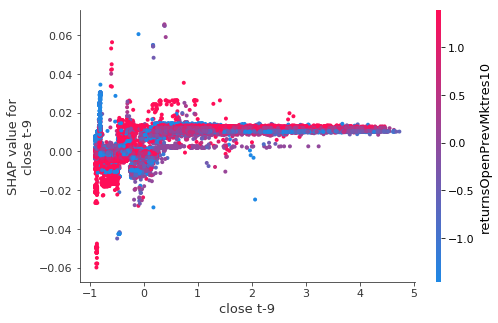

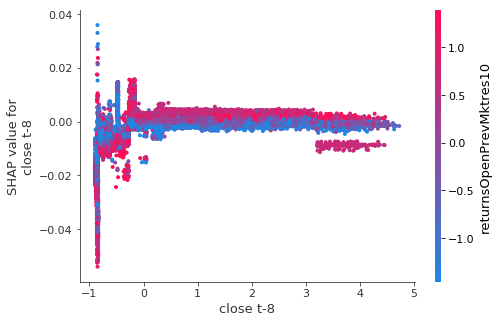

In [46]:
#shap.dependence_plot("EXT_SOURCE_2", shap_values, data_valid.iloc[:10000,:])
for i in reversed(inds2):
    shap.dependence_plot(i, shap_values, val)

## Improvements
- To try out neural network
- Do further analysis on each column
- Analyse more data as the whole dataset for news is 4.6GB from 2007 to 2016